In [93]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [94]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 29 05:46:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              28W /  70W |    223MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [95]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


#Рівняння Бюргерса. Точний розв'язок

$\displaystyle \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

**Тестова задача.**

Домен $x \in [0,2]$, $\nu=0.01$

Граничні умови

$U(0,t)=U(2,t)=0$


Початкові умови

$\displaystyle u(x,0) =  2 \nu \pi \frac{\sin(\pi x) +4 \sin(2 \pi x)}{4+\cos(\pi x)+2 \cos(2 \pi x)}$


[Ali Başhan. Nonlinear dynamics of the Burgers’ equation and numerical experiments Mathematical Sciences. 2021. https://doi.org/10.1007/s40096-021-00410-8
]:

**Точний розв'язок**

[J.D. Cole, On a quasi-linear parabolic equation occurring in aerodynamics, Quart. of Appl. Math., 9 (1951), pp. 225-236.]

$\displaystyle u(x,t) =  2 \nu \pi \frac{\sin(\pi x)e^{-\pi^2 \nu t}+4 \sin(2 \pi x)e^{-4 \pi^2 \nu t}}{4+\cos(\pi x)e^{-\pi^2 \nu t}+2 \cos(2 \pi x)e^{-4 \pi^2 \nu t}}$



In [96]:
import numpy

np.exp(4*np.pi**2*0.01*0.9)

1.4266167877247173

In [97]:
import sympy as sp

# Оголошуємо символ x
x, t, t0, nu = sp.symbols('x t t0 nu')

# U = 2*nu*sp.pi*((sp.sin(sp.pi*x)*sp.exp(-sp.pi**2*nu**2*t)+4*sp.sin(2*sp.pi*x)*sp.exp(-4*sp.pi**2*nu**2*t))/(4+sp.cos(sp.pi*x)*sp.exp(-sp.pi**2*nu**2*t)+2*sp.cos(2*sp.pi*x)*sp.exp(-4*sp.pi**2*nu**2*t)))

U = 2*nu*sp.pi*((sp.sin(sp.pi*x)*sp.exp(-sp.pi**2*nu*t)+4*sp.sin(2*sp.pi*x)*sp.exp(-4*sp.pi**2*nu*t))/(4+sp.cos(sp.pi*x)*sp.exp(-sp.pi**2*nu*t)+2*sp.cos(2*sp.pi*x)*sp.exp(-4*sp.pi**2*nu*t)))

In [98]:
U

2*pi*nu*(exp(-pi**2*nu*t)*sin(pi*x) + 4*exp(-4*pi**2*nu*t)*sin(2*pi*x))/(4 + exp(-pi**2*nu*t)*cos(pi*x) + 2*exp(-4*pi**2*nu*t)*cos(2*pi*x))

In [99]:
nu_val = 0.01


In [100]:
U_subs = U.subs({nu:nu_val})


# v_subs = v.subs({L:1, beta_n:7.8537, b:7.8537, phi:0, w:100.7245})
# V_subs = V.subs({L:1, beta_n:7.8537, b:7.8537, phi:0, w:100.7245})

In [101]:
f_U = sp.lambdify((x, t), U_subs, "numpy")

x_val = np.linspace(0, 2, num=201)
t_val = np.linspace(0, 1, num=101)

X_val, T_val = np.meshgrid(x_val, t_val)

U_val = f_U(X_val, T_val)

U_val = U_val.T




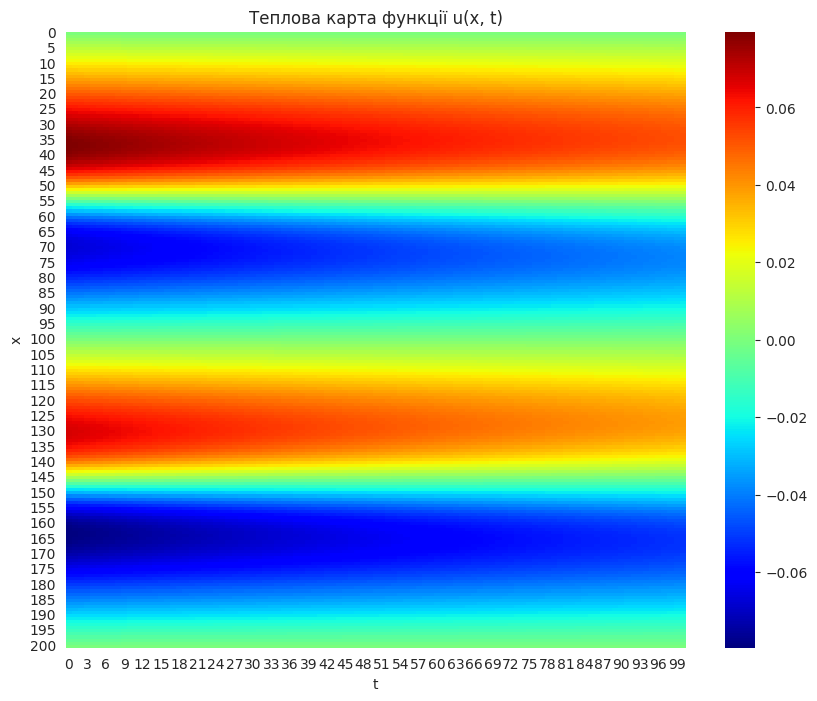

In [102]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(U_val, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()


In [103]:
t_val[100]

1.0

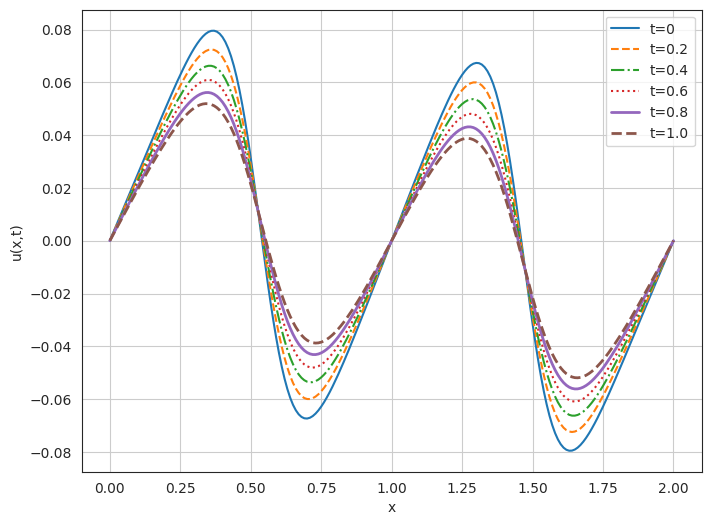

In [104]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x_val, U_val[:,0], label='t=0', linestyle='-')
plt.plot(x_val, U_val[:,20], label='t=0.2', linestyle='--')
plt.plot(x_val, U_val[:,40], label='t=0.4', linestyle='-.')
plt.plot(x_val, U_val[:,60], label='t=0.6', linestyle=':')
plt.plot(x_val, U_val[:,80], label='t=0.8', linestyle='-', linewidth=2)
plt.plot(x_val, U_val[:,100], label='t=1.0', linestyle='--', linewidth=2)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


#Розв'язок засобами PINN

In [105]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32,32),
            # nn.Tanh(),
            # nn.Linear(20,20),

            nn.Tanh(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [106]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [107]:
# h = 0.01
# k = 0.01
# nu = 0.5

# x = torch.arange(0,8+h, h)
# t = torch.arange(0,5+k, k)

# X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
# bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T

# # bc2[:,1]+10e-5
# # X[:,1]
# # bc2.size()
# # X.size()
# y_bc2 = (bc2[:,0]/(bc2[:,1]+10e-6))*1/(1+torch.sqrt((bc2[:,1]+10e-6)*nu/0.125)*torch.exp(bc2[:,0]**2/4*nu*(bc2[:,1]+10e-6)))
# y_bc2

torch.pi

3.141592653589793

In [108]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        self.x_max = 2
        self.t_max = 1

        # comp. domain
        self.h = 0.01
        self.k = 0.01
        self.nu = 0.01
        self.epoch = 2000

        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(0, self.t_max + self.k, self.k)


        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        # ic2  = torch.stack(torch.meshgrid(x,t[-1])).reshape(2,-1).T
        # print('bc1, ', bc1.shape)
        # print('bc2, ', bc2.shape)
        # print('ic, ', ic.shape)
        # breakpoint()

        self.X_train = torch.cat([bc1, bc2, ic])

        # print('self.X_train ', self.X_train.shape)
        # breakpoint()

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))

        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        y_ic  = 2 * self.nu * torch.pi * (torch.sin(torch.pi*ic[:,0]) + 4 * torch.sin(2 * torch.pi * ic[:,0]))/(4 + torch.cos(torch.pi * ic[:,0])+2*torch.cos(2 *torch.pi * ic[:,0]))

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])


        self.y_train = self.y_train.unsqueeze(1)



        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - self.nu * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
            print(loss_pde.item())
            print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [109]:
# training
net = Net()
net.train()

100 0.001238848315551877
2.714832589845173e-05
0.0012117000296711922
200 0.0012119848979637027
1.8980532331625e-05
0.0011930043110623956
300 0.0011976520763710141
1.3782063433609437e-05
0.0011838700156658888
400 0.0011886872816830873
1.1099934454250615e-05
0.0011775873135775328
500 0.00118290726095438
1.0203824786003679e-05
0.0011727034579962492
600 0.001178790582343936
1.0219414434686769e-05
0.0011685711797326803
700 0.0011754685547202826
1.0539619324845262e-05
0.001164928893558681
800 0.0011724987998604774
1.085287567548221e-05
0.0011616459814831614
900 0.001169665134511888
1.1039389391953591e-05
0.0011586257023736835
1000 0.0011668630177155137
1.107439038605662e-05
0.001155788660980761
1100 0.0011640491429716349
1.0973344615194947e-05
0.001153075834736228
1200 0.0011612140806391835
1.0765561455627903e-05
0.0011504485737532377
1300 0.0011583741288632154
1.0483950973139144e-05
0.001147890230640769
1400 0.0011555601377040148
1.0160145393456332e-05
0.001145399990491569
1500 0.0011528126

In [110]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [111]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(0, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

In [112]:
X

tensor([[0.0000, 0.0000],
        [0.0000, 0.0100],
        [0.0000, 0.0200],
        ...,
        [2.0000, 0.9800],
        [2.0000, 0.9900],
        [2.0000, 1.0000]], device='cuda:0')

In [113]:
X.shape

torch.Size([20301, 2])

In [114]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [115]:
y_pred.shape

(201, 101)

In [116]:
y_pred

array([[ 6.6027045e-05,  1.5686452e-04,  2.4603307e-04, ...,
        -3.2310635e-03, -3.3402592e-03, -3.4475476e-03],
       [ 1.7890781e-03,  1.8839687e-03,  1.9781440e-03, ...,
        -4.7017634e-04, -5.6602061e-04, -6.6162646e-04],
       [ 3.5939068e-03,  3.6907047e-03,  3.7860721e-03, ...,
         2.1700710e-03,  2.0856708e-03,  2.0017475e-03],
       ...,
       [-2.8303713e-03, -2.9134154e-03, -2.9926300e-03, ...,
        -5.2240789e-03, -5.2309036e-03, -5.2359104e-03],
       [ 1.6357005e-04,  6.2614679e-05, -3.4943223e-05, ...,
        -3.5008192e-03, -3.5158247e-03, -3.5313368e-03],
       [ 3.0996799e-03,  2.9807389e-03,  2.8656870e-03, ...,
        -1.8467754e-03, -1.8718243e-03, -1.8954277e-03]], dtype=float32)

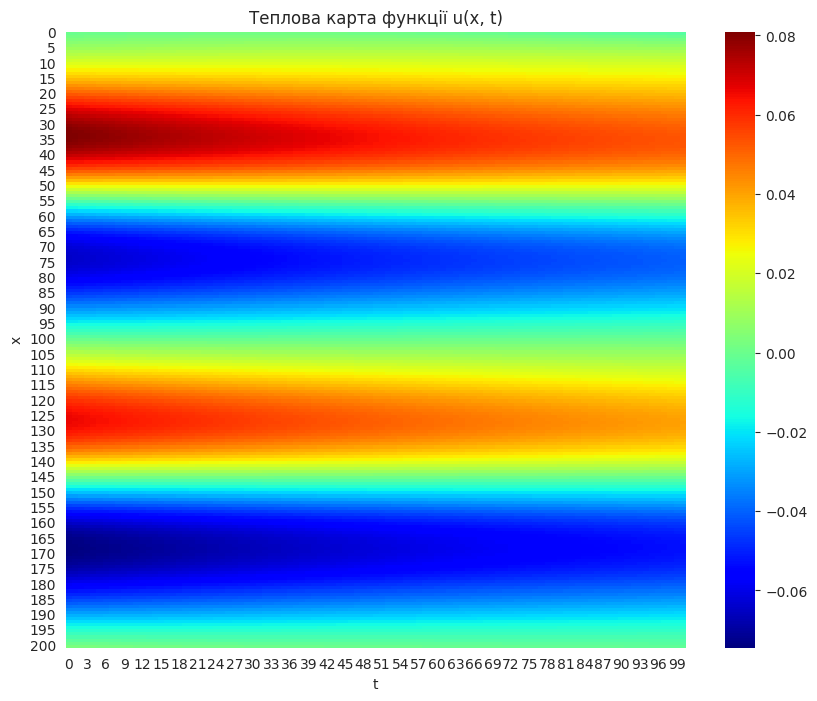

In [117]:
sns.set_style("white")
plt.figure(figsize=(10,8))
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Теплова карта функції u(x, t)')
plt.show()



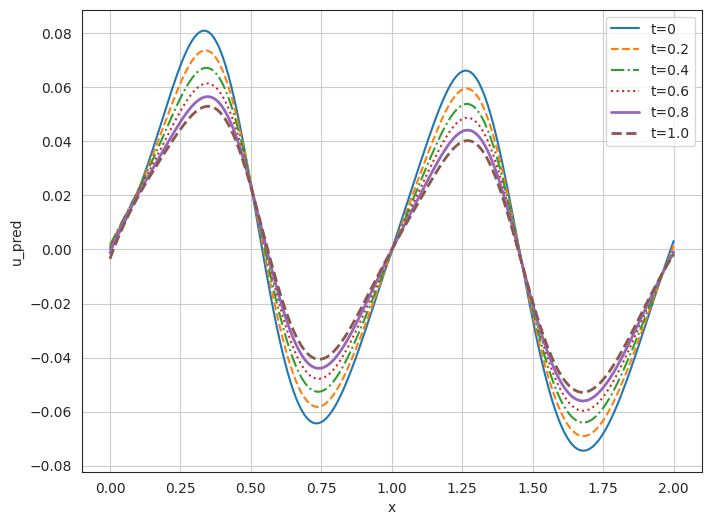

In [139]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(x, y_pred[:,0], label='t=0', linestyle='-')
plt.plot(x, y_pred[:,20], label='t=0.2', linestyle='--')
plt.plot(x, y_pred[:,40], label='t=0.4', linestyle='-.')
plt.plot(x, y_pred[:,60], label='t=0.6', linestyle=':')
plt.plot(x, y_pred[:,80], label='t=0.8', linestyle='-', linewidth=2)
plt.plot(x, y_pred[:,100], label='t=1.0', linestyle='--', linewidth=2)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('x')
plt.ylabel('u_pred')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


Порівняння з іншими результатами

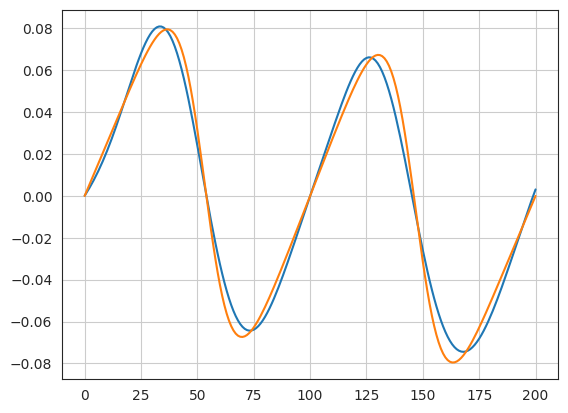

In [119]:
plt.plot(y_pred[:,0])
plt.plot(U_val[:,0])
plt.grid(True)
plt.show()

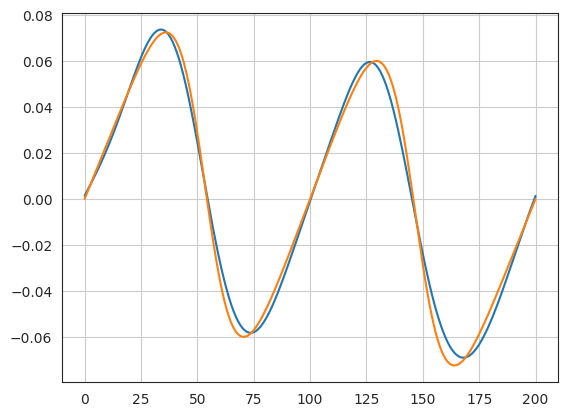

In [120]:
plt.plot(y_pred[:,20])
plt.plot(U_val[:,20])
plt.grid(True)
plt.show()

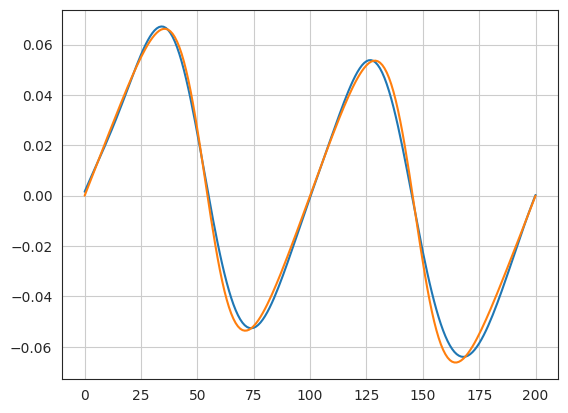

In [121]:
plt.plot(y_pred[:,40])
plt.plot(U_val[:,40])
plt.grid(True)
plt.show()

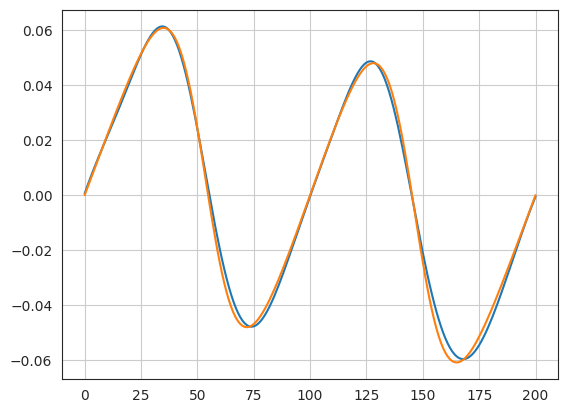

In [122]:
plt.plot(y_pred[:,60])
plt.plot(U_val[:,60])
plt.grid(True)
plt.show()

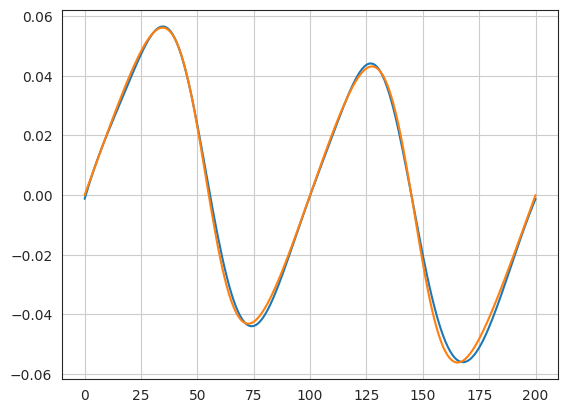

In [123]:
plt.plot(y_pred[:,80])
plt.plot(U_val[:,80])
plt.grid(True)
plt.show()

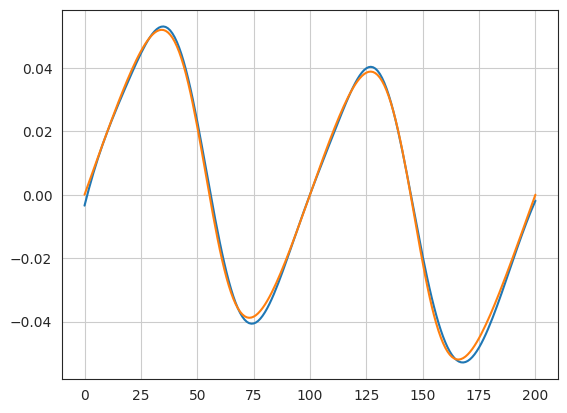

In [124]:
plt.plot(y_pred[:,100])
plt.plot(U_val[:,100])
plt.grid(True)
plt.show()

In [125]:
U_val.shape

(201, 101)

In [126]:
y_pred.shape

(201, 101)

In [127]:
from sklearn.metrics import r2_score

r2_score(U_val, y_pred)

0.9938503038385914

#Обернена задача

In [128]:
class Net_inv:
    def __init__(self, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.viscosity_coeff = 0.01
        lambda_value = 1.0


        print("the real value =",self.viscosity_coeff, "     Our I-PINNs value=", lambda_value)
        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).float().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.x_max = 2
        self.t_max = 1
        # comp. domain
        self.h = 0.01
        self.k = 0.01

        self.epoch = 6000

        self.lambda_hist = []
        x = torch.arange(0, self.x_max + self.h, self.h)
        t = torch.arange(0, self.t_max + self.k, self.k)




        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        # print('self.X ', self.X.shape)
        # breakpoint()

        print(self.X)

        # train data

        self.X_train = self.X

        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print(self.y_train)

        # breakpoint()

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 8000,
            max_eval = 8000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)

        # print('y_pred ', y_pred.shape)
        # print('self.y_train.shape ', self.y_train.shape)
        # breakpoint()


        loss_data = self.criterion(y_pred - self.y_train, torch.zeros_like(self.y_train))

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # print('du_dx ', du_dx.shape)
        # print('du_dt ', du_dt.shape)
        # breakpoint()


        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        lambda_pde  = self.lambda_value

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx - lambda_pde * du_dxx, torch.zeros_like(du_dxx))

        loss = loss_pde + loss_data
        loss.backward()

        self.lambda_hist.append(self.lambda_value.item())
        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",self.viscosity_coeff,"IPINN lambda=", self.lambda_value.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [129]:
net_inv = Net_inv(y_pred)
net_inv.train()
net_inv.model.eval()

the real value = 0.01      Our I-PINNs value= 1.0
tensor([[0.0000, 0.0000],
        [0.0000, 0.0100],
        [0.0000, 0.0200],
        ...,
        [2.0000, 0.9800],
        [2.0000, 0.9900],
        [2.0000, 1.0000]])
tensor([[ 6.6027e-05],
        [ 1.5686e-04],
        [ 2.4603e-04],
        ...,
        [-1.8468e-03],
        [-1.8718e-03],
        [-1.8954e-03]])
iteration number = 100  loss value = 0.001437244238331914 real mu= 0.01 IPINN lambda= 0.9863268733024597
iteration number = 200  loss value = 0.0013048205291852355 real mu= 0.01 IPINN lambda= 0.9840545654296875
iteration number = 300  loss value = 0.0012694422621279955 real mu= 0.01 IPINN lambda= 0.9830337166786194
iteration number = 400  loss value = 0.0012558788293972611 real mu= 0.01 IPINN lambda= 0.9818227887153625
iteration number = 500  loss value = 0.0012487571220844984 real mu= 0.01 IPINN lambda= 0.9805597066879272
iteration number = 600  loss value = 0.001244493410922587 real mu= 0.01 IPINN lambda= 0.97937941551

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [130]:
h = 0.01
k = 0.01

x = torch.arange(0, net.x_max+h,h)
t = torch.arange(0, net.t_max+k,k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net_inv.model
model.eval()
with torch.no_grad():
    y_pred_inv = model(X)
    y_pred_inv = y_pred_inv.reshape(len(x),len(t)).cpu().numpy()

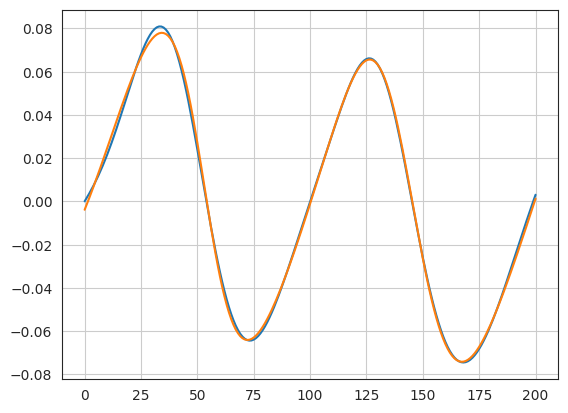

In [131]:
plt.plot(y_pred[:,0])
plt.plot(y_pred_inv[:,0])

plt.grid(True)
plt.show()

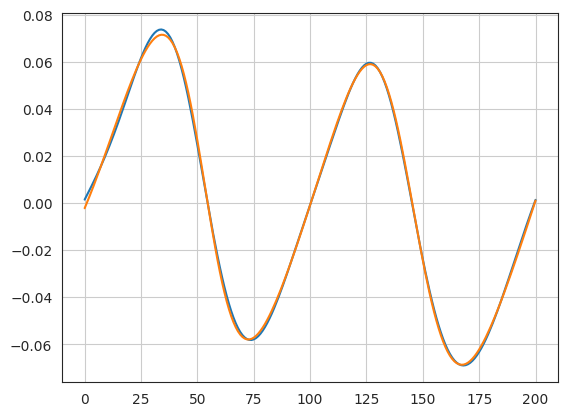

In [132]:
plt.plot(y_pred[:,20])
plt.plot(y_pred_inv[:,20])

plt.grid(True)
plt.show()

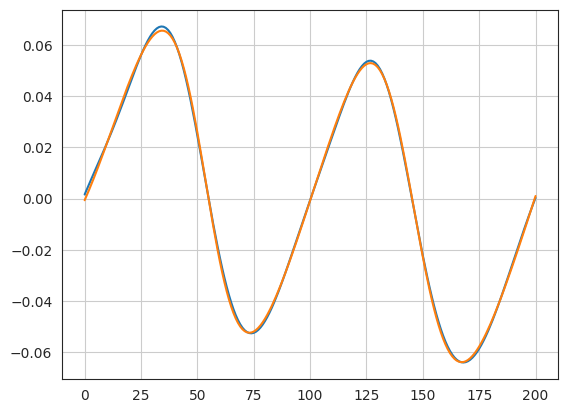

In [133]:
plt.plot(y_pred[:,40])
plt.plot(y_pred_inv[:,40])

plt.grid(True)
plt.show()

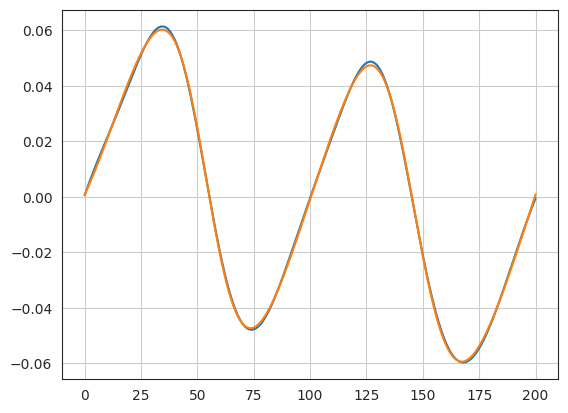

In [134]:
plt.plot(y_pred[:,60])
plt.plot(y_pred_inv[:,60])

plt.grid(True)
plt.show()

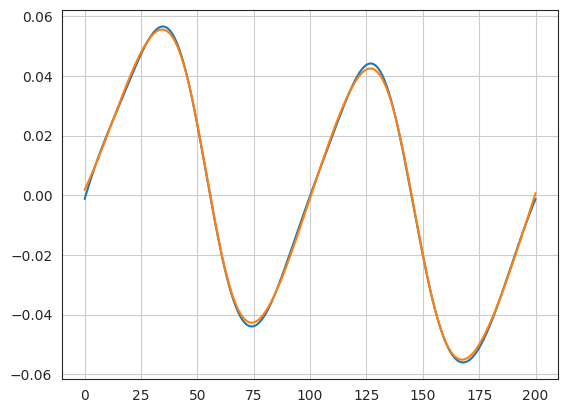

In [135]:
plt.plot(y_pred[:,80])
plt.plot(y_pred_inv[:,80])

plt.grid(True)
plt.show()

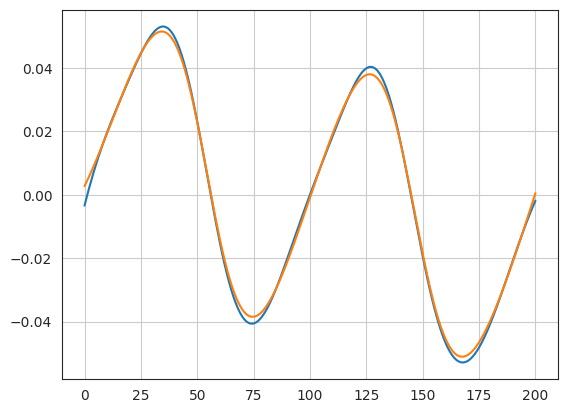

In [136]:
plt.plot(y_pred[:,100])
plt.plot(y_pred_inv[:,100])

plt.grid(True)
plt.show()

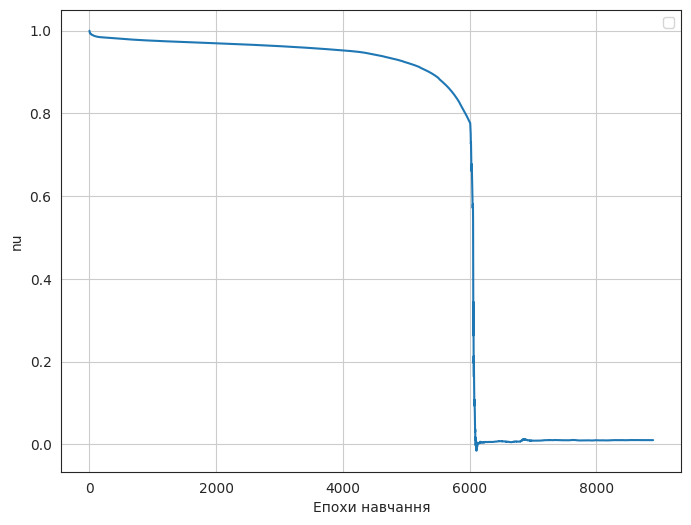

In [137]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('nu')
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


In [138]:
np.abs(net.nu - net_inv.lambda_hist[-1])/net.nu*100

4.577736929059027